# Analyse des données du Covid-19 du Burkina Faso
        -- SANOU Mohamed Bachir
        -- Master Science de Données (Ecole Supérieur d'informatique)
        -- Février 2023

## Chargement des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import datetime

## Importation des données

In [2]:
dtf = pd.read_excel("ObservationData.xlsx")
dtf.head()

,date,cas
0,12/10/2020,139
1,12/11/2020,107
2,12/12/2020,109
3,12/13/2020,162
4,12/14/2020,54


Pour faire une anlyse des series temporelles nous allons fixé la date comme index de notre dataset

## Importons les données en fixant comme index la colonne date

In [3]:
dtf = pd.read_excel("ObservationData.xlsx",index_col='date', parse_dates=True)
dtf.index

DatetimeIndex(['2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13',
               '2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17',
               '2020-12-18', '2020-12-19',
               ...
               '2022-10-30', '2022-11-13', '2022-11-20', '2022-11-27',
               '2022-12-04', '2022-12-11', '2022-12-25', '2023-01-08',
               '2023-01-15', '2023-01-22'],
              dtype='datetime64[ns]', name='date', length=497, freq=None)

## Verifions s'il n'y as pas de données vide

In [4]:
dtf.isna().sum()


cas    0
dtype: int64

Nous constatons qu'il n'y a pas de données vide

## Affichons la figure de l'evolution du coronavirus au Burkina

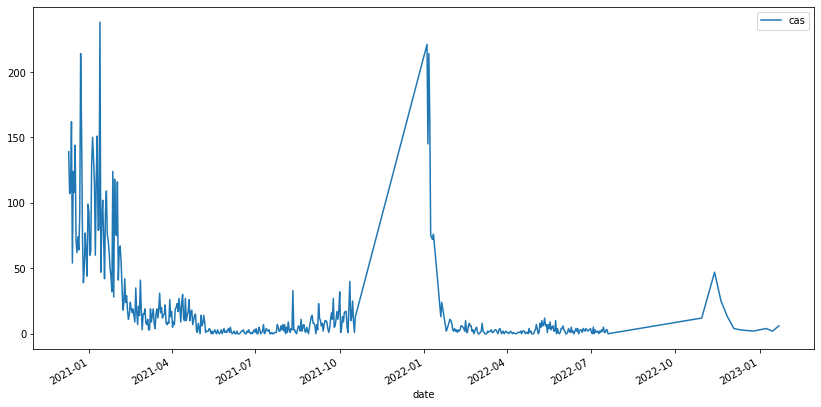

In [5]:

dtf.plot(figsize=(14,7))
plt.legend()
plt.show()

En analysant cette figure nous constatons qu'il y'avais beaucoup de cas du coronavirus dans les debuts de l'année 2021, et même qu'il à atteint son plus haut niveau en 2021. Aussi nous constatons que c'est au debut des années c'est à dire au moement de la fraicheur qu'on enregistre une augmentation du nombre de cas de coronavirus. Donc il se peut que le climat joue sur cette maladie.

## Voyons l'année à laquelle on atteint le premier maximum


In [6]:
dtf.idxmax()

cas   2021-01-13
dtype: datetime64[ns]

In [7]:
dtf[dtf.index == '2021-01-13' ]

,cas
date,
2021-01-13,238


Nous voyons effectivement que le maximum des cas de covid 19 enregistré au Burkina Faso à été atteint en 2021 précisement le 13 janvier avec 238 cas 

## Voyons a present la figure d'evolution du corona virus de l'anneée 2021

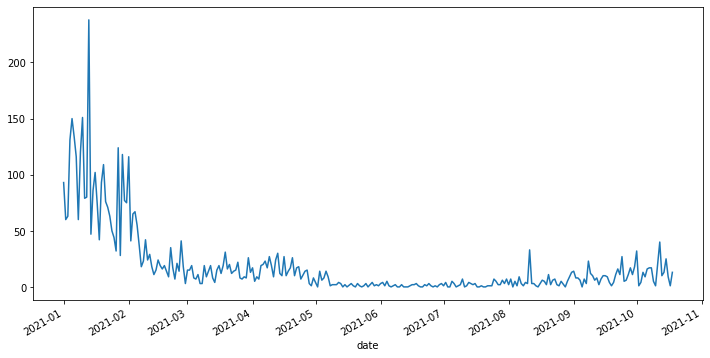

In [8]:
dtf.loc['2021']['cas'].plot(figsize=(12,6))
plt.show()

Observons avec la moyenne par mois et par semaine

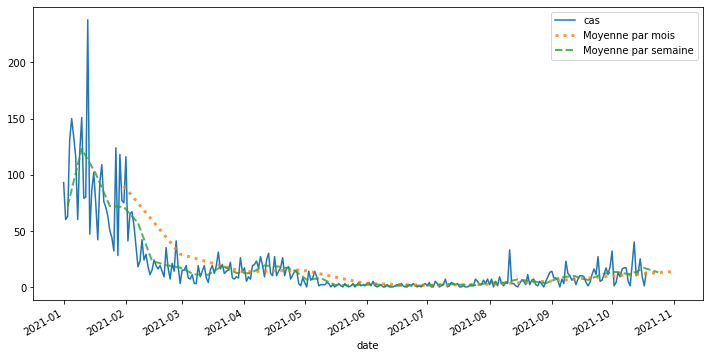

In [9]:
plt.figure(figsize=(12,6))
dtf.loc['2021', 'cas'].plot()
dtf.loc['2021', 'cas'].resample('M').mean().plot(label="Moyenne par mois", lw=3, ls=':', alpha=0.8)
dtf.loc['2021', 'cas'].resample('W').mean().plot(label="Moyenne par semaine", lw=2, ls='--', alpha=0.8)
plt.legend()
plt.show()

Nous voyons en analysant la figure qu'en 2021 pendant les 02 premiers mois (mois de fraicheur) on enregistrait beaucoup de cas de coronavirus, qui par la suite à commencer à baisser à partir du 03 mois (mois de chaleur). Ensuite on remarque que le nombre de cas commence à augmenter à partir du 09ème mois.

## Moyenne mobile et Moyenne mobile exponentielle

. Moyenne mobile

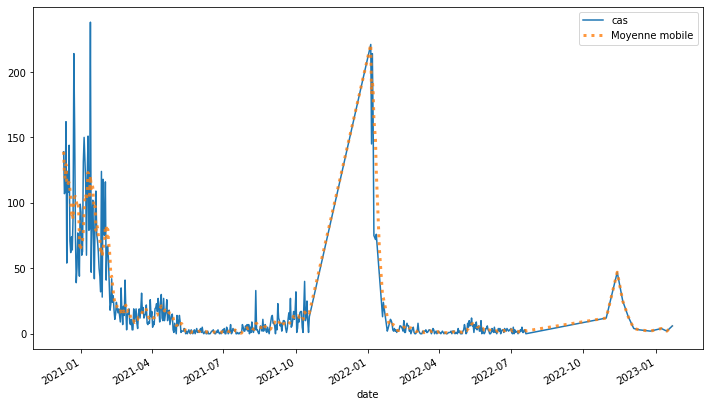

In [10]:
plt.figure(figsize=(12,7))
dtf['cas'].plot()
dtf['cas'].rolling('7D').mean().plot(label = "Moyenne mobile", lw =3 , ls=':', alpha = 0.8)
plt.legend()
plt.show()

Nous remarquons que la moyenne mobile ne suit pas bien l'evolution en 2021. Voyons cela plus en detail

. Plus en detail pour l'annee 2021

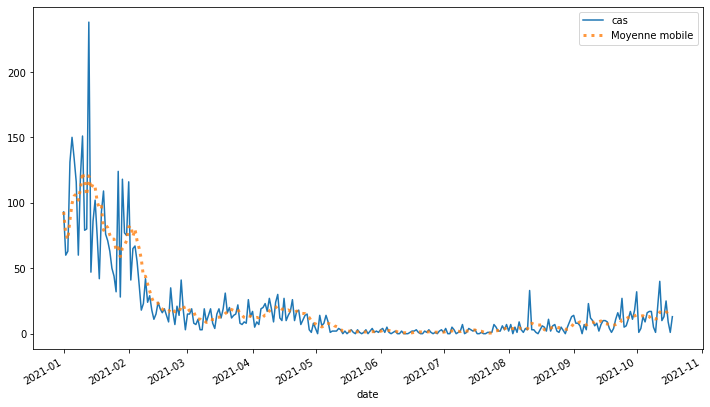

In [11]:
plt.figure(figsize=(12,7))
dtf.loc['2021']['cas'].plot()
dtf.loc['2021']['cas'].rolling('7D').mean().plot(label = "Moyenne mobile", lw =3 , ls=':', alpha = 0.8)
plt.legend()
plt.show()

Effectivement on se rend compte que la moyenne Mobile n'arrive pas à bien suivre l'evolution du coronavirus en 2021. Testons la methode de la moyenne mobile exponentielle sur tout le dataset et ensuite sur l'année 2021 pour comparer ces deux méthodes.

. Moyenne Mobile Exponentielle (MME)

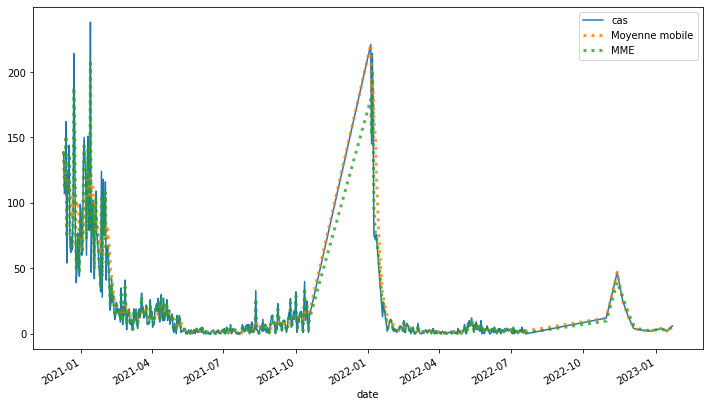

In [12]:
plt.figure(figsize=(12,7))
dtf['cas'].plot()
dtf['cas'].rolling('7D').mean().plot(label = "Moyenne mobile", lw =3 , ls=':', alpha = 0.8)
dtf['cas'].ewm(alpha=0.8).mean().plot(label='MME', lw=3, ls=':', alpha=0.8)
plt.legend()
plt.show()

D'une vue globale on pourrait dire que la moyenne mobile exponentielle suit mieux l'evolution du coronavirus par rapport à la moyenne mobile.
Voyons plus en details en  2021 pour comparer ces deux méthodes.

. Comparaisons en  2021

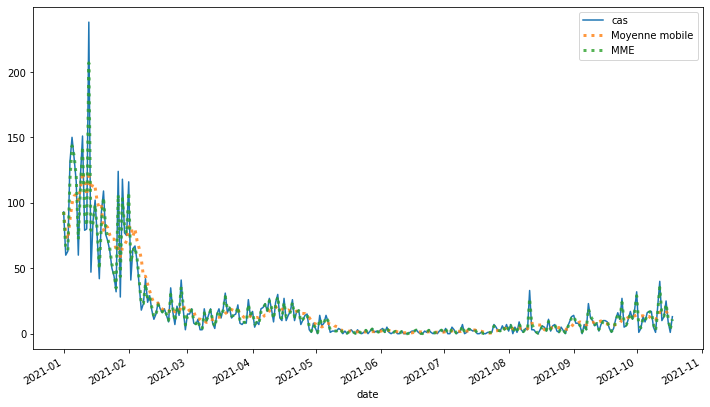

In [13]:
plt.figure(figsize=(12,7))
dtf.loc['2021']['cas'].plot()
dtf.loc['2021']['cas'].rolling('7D').mean().plot(label = "Moyenne mobile", lw =3 , ls=':', alpha = 0.8)
dtf.loc['2021']['cas'].ewm(alpha=0.8).mean().plot(label='MME', lw=3, ls=':', alpha=0.8)
plt.legend()
plt.show()

.Plus en details pour les 03 premiers mois

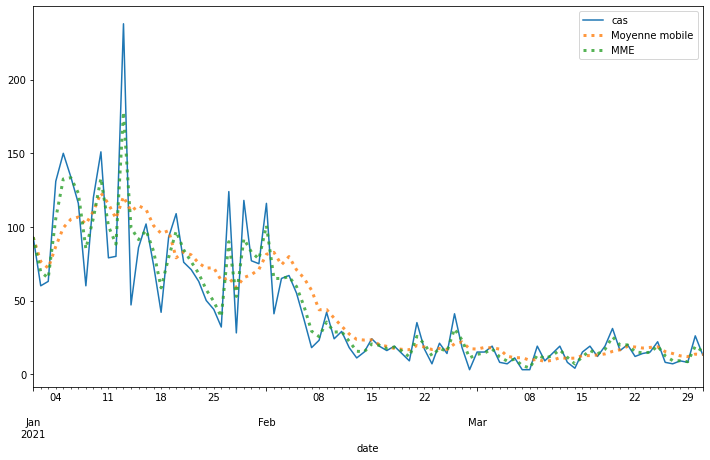

In [14]:
plt.figure(figsize=(12,7))
dtf.loc['2021-01' : '2021-03']['cas'].plot()
dtf.loc['2021-01': '2021-03']['cas'].rolling('7D').mean().plot(label = "Moyenne mobile", lw =3 , ls=':', alpha = 0.8)
dtf.loc['2021-01': '2021-03']['cas'].ewm(alpha=0.6).mean().plot(label='MME', lw=3, ls=':', alpha=0.8)
plt.legend()
plt.show()

On voit clairement qu'avec la moyenne mobile exponentielle on obtient un bon resultat

## Preparation des données de test et d'entraintement

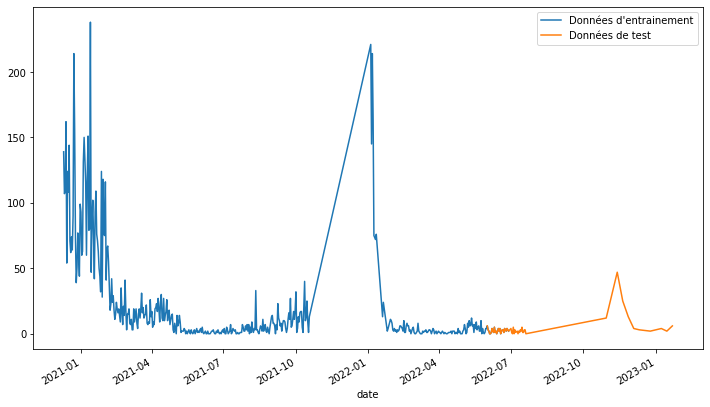

In [15]:
train = dtf.loc[:'2022-06']
test = dtf.loc['2022-06':]
plt.figure(figsize=(12,7))
train['cas'].plot(label = "Données d'entrainement")
test['cas'].plot(label = "Données de test")
plt.legend()
plt.show()

## Regression Linéaire

In [16]:
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)
#X_train, X_test, y_train, y_test = train_test_split(dtf.index, dtf['cas'], test_size=0.2, random_state=0)
X_train = np.arange(1,len(train.index)+1).reshape(-1, 1)
X_test = np.arange(1,len(test.index)+1).reshape(-1, 1)
y_train = train['cas'].values
y_test = test['cas'].values

Training data shape:  (468, 1)
Test data shape:  (57, 1)


In [17]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
pred = lin_reg.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'taux d\'erreur: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')
predictionLineaire = test
predictionLineaire['cas_pred'] = pred



taux d'erreur: 42.5 (93.1%)


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\83629124.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictionLineaire['cas_pred'] = pred


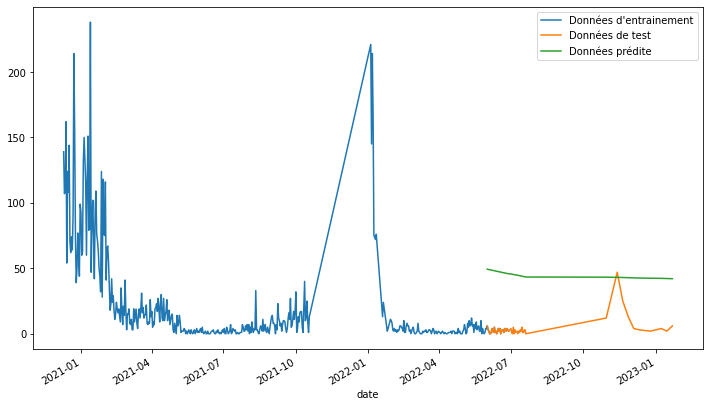

In [18]:
plt.figure(figsize=(12,7))
train['cas'].plot(label = "Données d'entrainement")
predictionLineaire['cas'].plot(label = "Données de test")
predictionLineaire['cas_pred'].plot(label = "Données prédite")
plt.legend()
plt.show()

## Regression polynomiale

In [19]:
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [20]:
pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Erreur: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Erreur: 64.3 (95.9%)


In [21]:
predictionPolynomiale = test
predictionPolynomiale['cas_pred'] = pred

C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\3325500589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictionPolynomiale['cas_pred'] = pred


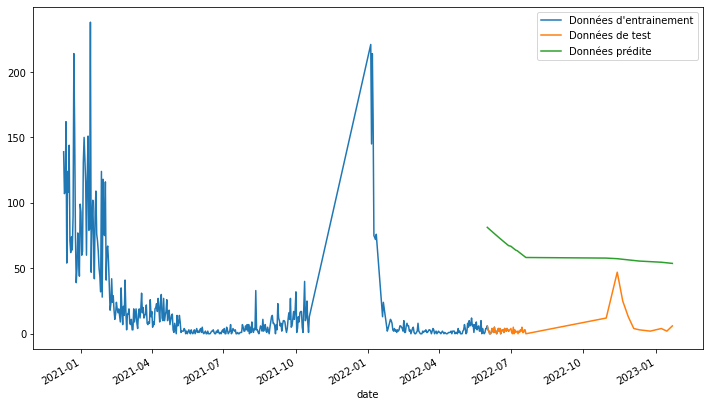

In [22]:
plt.figure(figsize=(12,7))
train['cas'].plot(label = "Données d'entrainement")
predictionPolynomiale['cas'].plot(label = "Données de test")
predictionPolynomiale['cas_pred'].plot(label = "Données prédite")
plt.legend()
plt.show()

## Lissage exponentielle simple

In [23]:
model = SimpleExpSmoothing(train.values)
model_fitted = model.fit()
pred = model_fitted.predict(len(train), len(train) + len(test)-1)
pred

array([2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172, 2.62983172, 2.62983172, 2.62983172,
       2.62983172, 2.62983172])

In [24]:
predictions = test
predictions['cas_pred'] = pred

C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\3568983086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


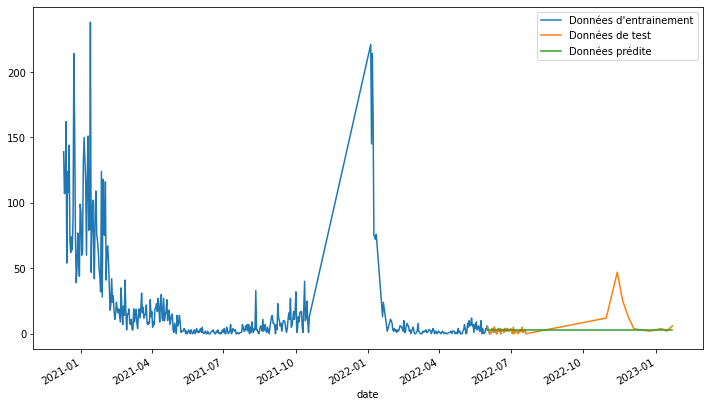

In [25]:
plt.figure(figsize=(12,7))
train['cas'].plot(label = "Données d'entrainement")
predictions['cas'].plot(label = "Données de test")
predictions['cas_pred'].plot(label = "Données prédite")
plt.legend()
plt.show()

## Lissage exponentielle double

. Methode non saisonière 

In [26]:
holt_ns = Holt(train.values).fit(smoothing_level=0.5, smoothing_trend=0.2,optimized=False)
pred = holt_ns.forecast(len(test) )
pred

array([2.65102279, 2.63010359, 2.60918438, 2.58826518, 2.56734597,
       2.54642677, 2.52550756, 2.50458836, 2.48366915, 2.46274995,
       2.44183075, 2.42091154, 2.39999234, 2.37907313, 2.35815393,
       2.33723472, 2.31631552, 2.29539632, 2.27447711, 2.25355791,
       2.2326387 , 2.2117195 , 2.19080029, 2.16988109, 2.14896189,
       2.12804268, 2.10712348, 2.08620427, 2.06528507, 2.04436586,
       2.02344666, 2.00252746, 1.98160825, 1.96068905, 1.93976984,
       1.91885064, 1.89793143, 1.87701223, 1.85609302, 1.83517382,
       1.81425462, 1.79333541, 1.77241621, 1.751497  , 1.7305778 ,
       1.70965859, 1.68873939, 1.66782019, 1.64690098, 1.62598178,
       1.60506257, 1.58414337, 1.56322416, 1.54230496, 1.52138576,
       1.50046655, 1.47954735])

            cas  cas_pred
date                     
2022-06-01    6  2.651023
2022-06-02    3  2.630104
2022-06-03    2  2.609184
2022-06-04    0  2.588265
2022-06-05    0  2.567346
2022-06-06    1  2.546427
2022-06-07    4  2.525508
2022-06-08    2  2.504588
2022-06-09    1  2.483669
2022-06-10    5  2.462750
2022-06-11    1  2.441831
2022-06-12    2  2.420912
2022-06-13    0  2.399992
2022-06-14    2  2.379073
2022-06-15    4  2.358154
2022-06-16    2  2.337235
2022-06-17    4  2.316316
2022-06-18    0  2.295396
2022-06-19    2  2.274477
2022-06-20    3  2.253558
2022-06-21    3  2.232639
2022-06-22    1  2.211719
2022-06-23    4  2.190800
2022-06-24    3  2.169881
2022-06-25    2  2.148962
2022-06-26    4  2.128043
2022-06-27    3  2.107123
2022-06-28    2  2.086204
2022-07-01    4  2.065285
2022-07-02    1  2.044366
2022-07-03    0  2.023447
2022-07-04    5  2.002527
2022-07-05    0  1.981608
2022-07-06    3  1.960689
2022-07-07    1  1.939770
2022-07-09    2  1.918851
2022-07-10  

C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\881954765.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


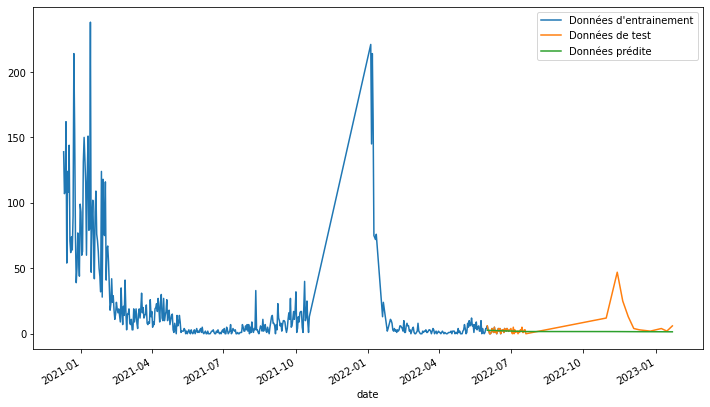

In [27]:
predictions = test
predictions['cas_pred'] = pred
print(predictions)
plt.figure(figsize=(12,7))
train['cas'].plot(label = "Données d'entrainement")
predictions['cas'].plot(label = "Données de test")
predictions['cas_pred'].plot(label = "Données prédite")
plt.legend()
plt.show()

            cas  cas_pred
date                     
2022-06-01    6  2.110729
2022-06-02    3  2.008167
2022-06-03    2  1.925739
2022-06-04    0  1.859493
2022-06-05    0  1.806252
2022-06-06    1  1.763462
2022-06-07    4  1.729073
2022-06-08    2  1.701434
2022-06-09    1  1.679222
2022-06-10    5  1.661370
2022-06-11    1  1.647022
2022-06-12    2  1.635491
2022-06-13    0  1.626224
2022-06-14    2  1.618776
2022-06-15    4  1.612790
2022-06-16    2  1.607979
2022-06-17    4  1.604113
2022-06-18    0  1.601006
2022-06-19    2  1.598508
2022-06-20    3  1.596501
2022-06-21    3  1.594888
2022-06-22    1  1.593592
2022-06-23    4  1.592550
2022-06-24    3  1.591712
2022-06-25    2  1.591039
2022-06-26    4  1.590499
2022-06-27    3  1.590064
2022-06-28    2  1.589715
2022-07-01    4  1.589434
2022-07-02    1  1.589208
2022-07-03    0  1.589027
2022-07-04    5  1.588881
2022-07-05    0  1.588764
2022-07-06    3  1.588670
2022-07-07    1  1.588594
2022-07-09    2  1.588533
2022-07-10  

C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\1626189698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


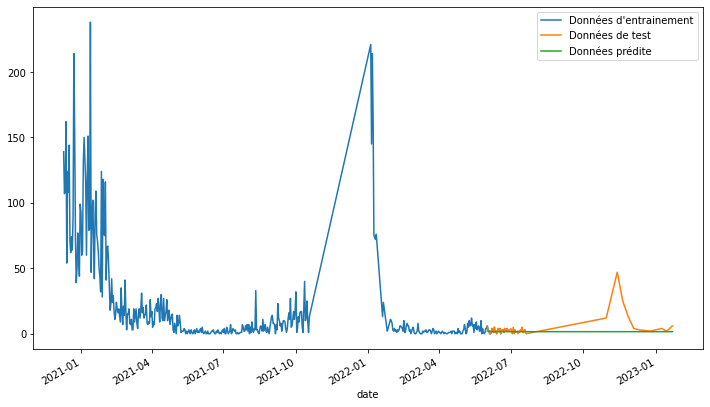

In [28]:
holt_ns = Holt(train.values, damped_trend=True).fit(smoothing_level=0.8, smoothing_trend=0.2)
pred = holt_ns.forecast(len(test) )
pred
predictions = test
predictions['cas_pred'] = pred
print(predictions)
plt.figure(figsize=(12,7))
train['cas'].plot(label = "Données d'entrainement")
predictions['cas'].plot(label = "Données de test")
predictions['cas_pred'].plot(label = "Données prédite")
plt.legend()
plt.show()



. Methode saisonnière additve

            cas  cas_pred
date                     
2022-06-01    6  0.640526
2022-06-02    3  2.376936
2022-06-03    2  3.069577
2022-06-04    0  1.101607
2022-06-05    0 -0.089817
2022-06-06    1  1.646594
2022-06-07    4  2.339235
2022-06-08    2  0.371265
2022-06-09    1 -0.820159
2022-06-10    5  0.916251
2022-06-11    1  1.608893
2022-06-12    2 -0.359077
2022-06-13    0 -1.550501
2022-06-14    2  0.185909
2022-06-15    4  0.878551
2022-06-16    2 -1.089419
2022-06-17    4 -2.280843
2022-06-18    0 -0.544433
2022-06-19    2  0.148209
2022-06-20    3 -1.819762
2022-06-21    3 -3.011185
2022-06-22    1 -1.274775
2022-06-23    4 -0.582133
2022-06-24    3 -2.550104
2022-06-25    2 -3.741527
2022-06-26    4 -2.005117
2022-06-27    3 -1.312475
2022-06-28    2 -3.280446
2022-07-01    4 -4.471869
2022-07-02    1 -2.735459
2022-07-03    0 -2.042817
2022-07-04    5 -4.010788
2022-07-05    0 -5.202211
2022-07-06    3 -3.465801
2022-07-07    1 -2.773159
2022-07-09    2 -4.741130
2022-07-10  

C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\3966034385.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


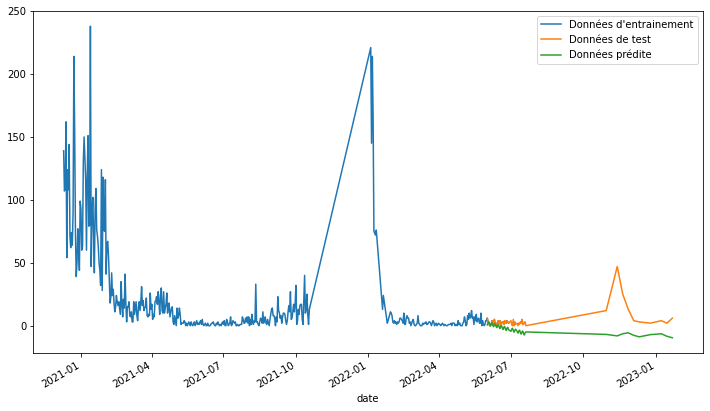

In [29]:
fit_add_1 = ExponentialSmoothing(train.values, seasonal_periods=4, trend='add',seasonal='add').fit()
pred = fit_add_1.forecast(len(test))
predictions = test
predictions['cas_pred'] = pred
print(predictions)
plt.figure(figsize=(12,7))
train['cas'].plot(label = "Données d'entrainement")
predictions['cas'].plot(label = "Données de test")
predictions['cas_pred'].plot(label = "Données prédite")
plt.legend()
plt.show()



## Methode ARIMA

            cas  cas_pred
date                     
2022-06-01    6  2.666720
2022-06-02    3  2.594390
2022-06-03    2  2.594977
2022-06-04    0  2.613875
2022-06-05    0  2.569492
2022-06-06    1  2.590837
2022-06-07    4  2.591183
2022-06-08    2  2.587872
2022-06-09    1  2.590152
2022-06-10    5  2.588602
2022-06-11    1  2.589016
2022-06-12    2  2.589247
2022-06-13    0  2.589017
2022-06-14    2  2.589122
2022-06-15    4  2.589088
2022-06-16    2  2.589082
2022-06-17    4  2.589100
2022-06-18    0  2.589089
2022-06-19    2  2.589092
2022-06-20    3  2.589092
2022-06-21    3  2.589091
2022-06-22    1  2.589092
2022-06-23    4  2.589092
2022-06-24    3  2.589092
2022-06-25    2  2.589092
2022-06-26    4  2.589092
2022-06-27    3  2.589092
2022-06-28    2  2.589092
2022-07-01    4  2.589092
2022-07-02    1  2.589092
2022-07-03    0  2.589092
2022-07-04    5  2.589092
2022-07-05    0  2.589092
2022-07-06    3  2.589092
2022-07-07    1  2.589092
2022-07-09    2  2.589092
2022-07-10  

C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\906308307.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


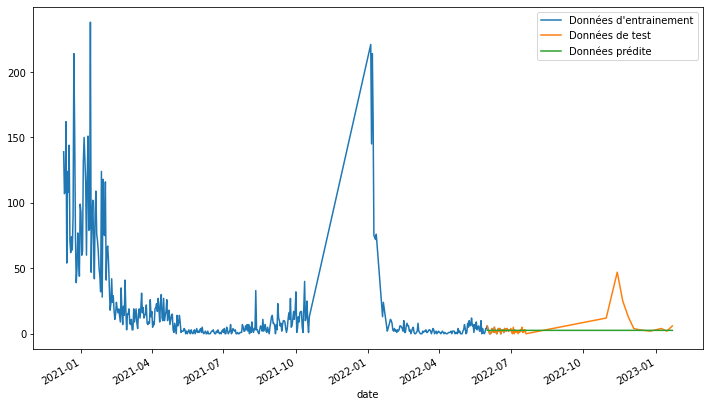

In [30]:
order = (4, 1, 0)
model_fit = ARIMA(train.values,order=order).fit()
pred = model_fit.predict(len(train), len(train)+ len(test)-1)
len(pred)
predictions = test
predictions['cas_pred'] = pred
print(predictions)
plt.figure(figsize=(12,7))
train['cas'].plot(label = "Données d'entrainement")
predictions['cas'].plot(label = "Données de test")
predictions['cas_pred'].plot(label = "Données prédite")
plt.legend()
plt.show()

In [31]:
def affichage_araima (train,test,p,q) :
    order = (p, 1, q)
    model_fit = ARIMA(train.values,order=order).fit()
    pred = model_fit.predict(len(train), len(train)+ len(test)-1)
    len(pred)
    predictions = test
    predictions['cas_pred'] = pred
    print(predictions)
    plt.figure(figsize=(12,7))
    train['cas'].plot(label = "Données d'entrainement")
    predictions['cas'].plot(label = "Données de test")
    predictions['cas_pred'].plot(label = "Données prédite")
    plt.legend()
    plt.show()

p : 1
q : 1
            cas  cas_pred
date                     
2022-06-01    6  2.416822
2022-06-02    3  2.537324
2022-06-03    2  2.572160
2022-06-04    0  2.582231
2022-06-05    0  2.585143
2022-06-06    1  2.585984
2022-06-07    4  2.586228
2022-06-08    2  2.586298
2022-06-09    1  2.586318
2022-06-10    5  2.586324
2022-06-11    1  2.586326
2022-06-12    2  2.586327
2022-06-13    0  2.586327
2022-06-14    2  2.586327
2022-06-15    4  2.586327
2022-06-16    2  2.586327
2022-06-17    4  2.586327
2022-06-18    0  2.586327
2022-06-19    2  2.586327
2022-06-20    3  2.586327
2022-06-21    3  2.586327
2022-06-22    1  2.586327
2022-06-23    4  2.586327
2022-06-24    3  2.586327
2022-06-25    2  2.586327
2022-06-26    4  2.586327
2022-06-27    3  2.586327
2022-06-28    2  2.586327
2022-07-01    4  2.586327
2022-07-02    1  2.586327
2022-07-03    0  2.586327
2022-07-04    5  2.586327
2022-07-05    0  2.586327
2022-07-06    3  2.586327
2022-07-07    1  2.586327
2022-07-09    2  2.586327


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


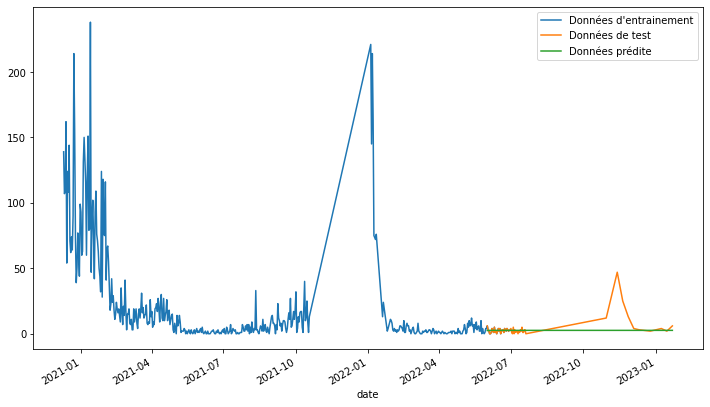

p : 1
q : 2
            cas  cas_pred
date                     
2022-06-01    6  2.488875
2022-06-02    3  2.510692
2022-06-03    2  2.526775
2022-06-04    0  2.538631
2022-06-05    0  2.547371
2022-06-06    1  2.553815
2022-06-07    4  2.558565
2022-06-08    2  2.562067
2022-06-09    1  2.564648
2022-06-10    5  2.566552
2022-06-11    1  2.567955
2022-06-12    2  2.568989
2022-06-13    0  2.569751
2022-06-14    2  2.570313
2022-06-15    4  2.570728
2022-06-16    2  2.571033
2022-06-17    4  2.571258
2022-06-18    0  2.571424
2022-06-19    2  2.571547
2022-06-20    3  2.571637
2022-06-21    3  2.571704
2022-06-22    1  2.571753
2022-06-23    4  2.571789
2022-06-24    3  2.571815
2022-06-25    2  2.571835
2022-06-26    4  2.571849
2022-06-27    3  2.571860
2022-06-28    2  2.571868
2022-07-01    4  2.571874
2022-07-02    1  2.571878
2022-07-03    0  2.571881
2022-07-04    5  2.571884
2022-07-05    0  2.571885
2022-07-06    3  2.571887
2022-07-07    1  2.571887
2022-07-09    2  2.571888


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


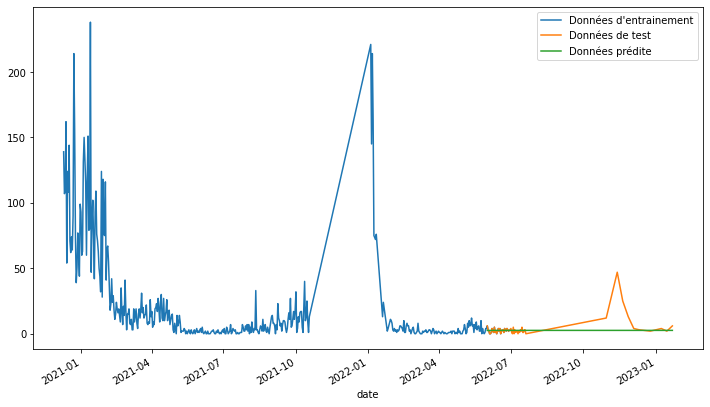

p : 1
q : 3
            cas  cas_pred
date                     
2022-06-01    6  2.490109
2022-06-02    3  2.485895
2022-06-03    2  2.508236
2022-06-04    0  2.524065
2022-06-05    0  2.535280
2022-06-06    1  2.543226
2022-06-07    4  2.548856
2022-06-08    2  2.552844
2022-06-09    1  2.555671
2022-06-10    5  2.557673
2022-06-11    1  2.559092
2022-06-12    2  2.560097
2022-06-13    0  2.560809
2022-06-14    2  2.561314
2022-06-15    4  2.561671
2022-06-16    2  2.561925
2022-06-17    4  2.562104
2022-06-18    0  2.562231
2022-06-19    2  2.562321
2022-06-20    3  2.562385
2022-06-21    3  2.562430
2022-06-22    1  2.562462
2022-06-23    4  2.562485
2022-06-24    3  2.562501
2022-06-25    2  2.562513
2022-06-26    4  2.562521
2022-06-27    3  2.562526
2022-06-28    2  2.562530
2022-07-01    4  2.562533
2022-07-02    1  2.562535
2022-07-03    0  2.562537
2022-07-04    5  2.562538
2022-07-05    0  2.562538
2022-07-06    3  2.562539
2022-07-07    1  2.562539
2022-07-09    2  2.562540


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


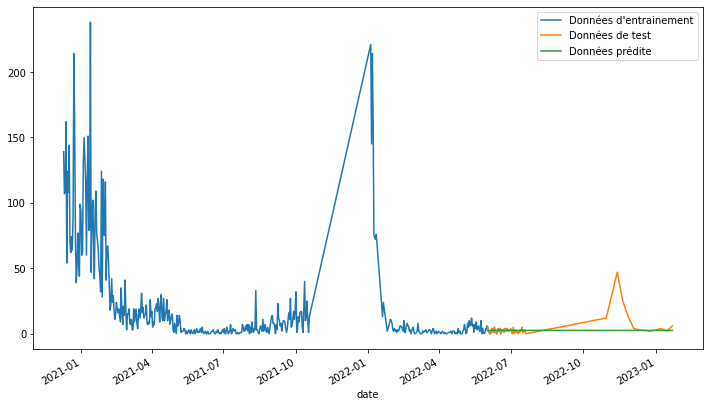

p : 1
q : 4
            cas  cas_pred
date                     
2022-06-01    6  2.607244
2022-06-02    3  2.428212
2022-06-03    2  2.361079
2022-06-04    0  2.499797
2022-06-05    0  2.531217
2022-06-06    1  2.538334
2022-06-07    4  2.539946
2022-06-08    2  2.540311
2022-06-09    1  2.540394
2022-06-10    5  2.540413
2022-06-11    1  2.540417
2022-06-12    2  2.540418
2022-06-13    0  2.540418
2022-06-14    2  2.540418
2022-06-15    4  2.540418
2022-06-16    2  2.540418
2022-06-17    4  2.540418
2022-06-18    0  2.540418
2022-06-19    2  2.540418
2022-06-20    3  2.540418
2022-06-21    3  2.540418
2022-06-22    1  2.540418
2022-06-23    4  2.540418
2022-06-24    3  2.540418
2022-06-25    2  2.540418
2022-06-26    4  2.540418
2022-06-27    3  2.540418
2022-06-28    2  2.540418
2022-07-01    4  2.540418
2022-07-02    1  2.540418
2022-07-03    0  2.540418
2022-07-04    5  2.540418
2022-07-05    0  2.540418
2022-07-06    3  2.540418
2022-07-07    1  2.540418
2022-07-09    2  2.540418


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


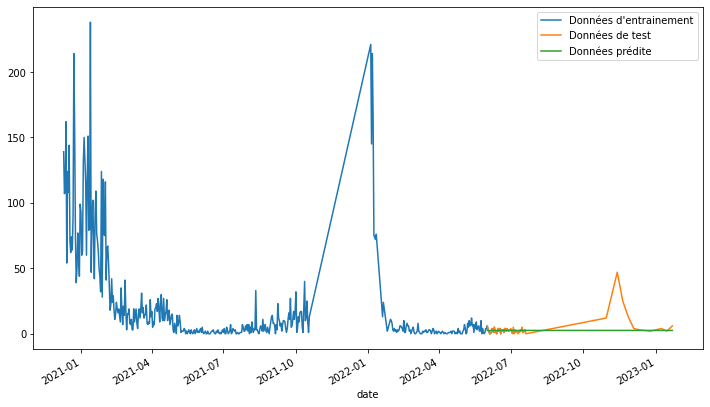

p : 2
q : 1
            cas  cas_pred
date                     
2022-06-01    6  2.412825
2022-06-02    3  2.414396
2022-06-03    2  2.473376
2022-06-04    0  2.494047
2022-06-05    0  2.509561
2022-06-06    1  2.517866
2022-06-07    4  2.522941
2022-06-08    2  2.525876
2022-06-09    1  2.527612
2022-06-10    5  2.528630
2022-06-11    1  2.529228
2022-06-12    2  2.529580
2022-06-13    0  2.529786
2022-06-14    2  2.529907
2022-06-15    4  2.529979
2022-06-16    2  2.530021
2022-06-17    4  2.530045
2022-06-18    0  2.530060
2022-06-19    2  2.530068
2022-06-20    3  2.530073
2022-06-21    3  2.530076
2022-06-22    1  2.530078
2022-06-23    4  2.530079
2022-06-24    3  2.530080
2022-06-25    2  2.530080
2022-06-26    4  2.530080
2022-06-27    3  2.530080
2022-06-28    2  2.530080
2022-07-01    4  2.530080
2022-07-02    1  2.530080
2022-07-03    0  2.530080
2022-07-04    5  2.530080
2022-07-05    0  2.530080
2022-07-06    3  2.530080
2022-07-07    1  2.530080
2022-07-09    2  2.530080


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


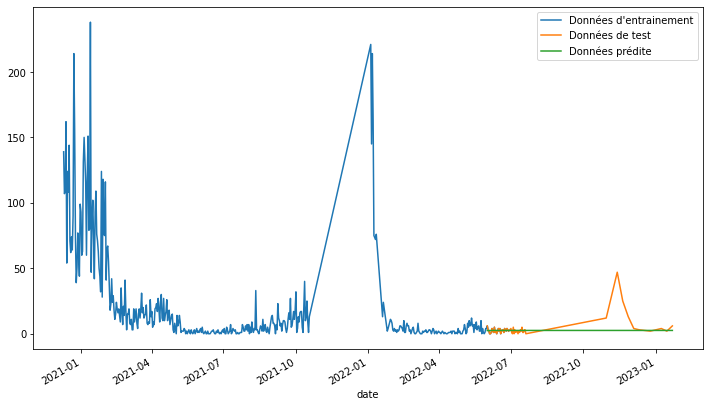

p : 2
q : 2
            cas  cas_pred
date                     
2022-06-01    6  2.489547
2022-06-02    3  2.496421
2022-06-03    2  2.516579
2022-06-04    0  2.530468
2022-06-05    0  2.540527
2022-06-06    1  2.547789
2022-06-07    4  2.553033
2022-06-08    2  2.556819
2022-06-09    1  2.559554
2022-06-10    5  2.561528
2022-06-11    1  2.562954
2022-06-12    2  2.563983
2022-06-13    0  2.564727
2022-06-14    2  2.565263
2022-06-15    4  2.565651
2022-06-16    2  2.565931
2022-06-17    4  2.566133
2022-06-18    0  2.566279
2022-06-19    2  2.566384
2022-06-20    3  2.566460
2022-06-21    3  2.566515
2022-06-22    1  2.566555
2022-06-23    4  2.566584
2022-06-24    3  2.566604
2022-06-25    2  2.566619
2022-06-26    4  2.566630
2022-06-27    3  2.566638
2022-06-28    2  2.566644
2022-07-01    4  2.566648
2022-07-02    1  2.566651
2022-07-03    0  2.566653
2022-07-04    5  2.566654
2022-07-05    0  2.566655
2022-07-06    3  2.566656
2022-07-07    1  2.566657
2022-07-09    2  2.566657


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


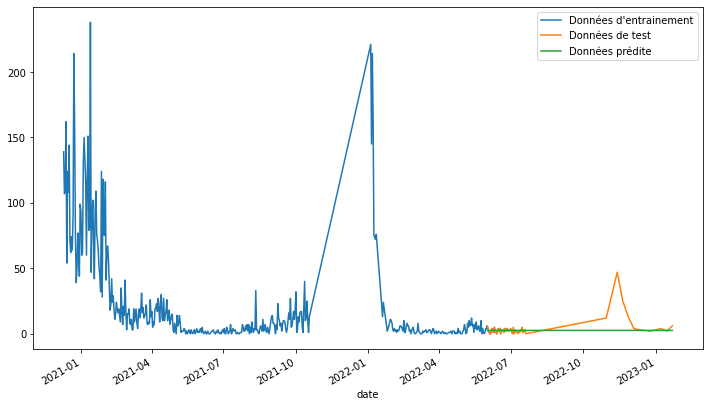

p : 2
q : 3
            cas  cas_pred
date                     
2022-06-01    6  2.499615
2022-06-02    3  2.529841
2022-06-03    2  2.535302
2022-06-04    0  2.550636
2022-06-05    0  2.554808
2022-06-06    1  2.562723
2022-06-07    4  2.565539
2022-06-08    2  2.569690
2022-06-09    1  2.571474
2022-06-10    5  2.573681
2022-06-11    1  2.574770
2022-06-12    2  2.575957
2022-06-13    0  2.576606
2022-06-14    2  2.577251
2022-06-15    4  2.577632
2022-06-16    2  2.577984
2022-06-17    4  2.578205
2022-06-18    0  2.578400
2022-06-19    2  2.578527
2022-06-20    3  2.578634
2022-06-21    3  2.578707
2022-06-22    1  2.578767
2022-06-23    4  2.578808
2022-06-24    3  2.578842
2022-06-25    2  2.578865
2022-06-26    4  2.578884
2022-06-27    3  2.578897
2022-06-28    2  2.578908
2022-07-01    4  2.578915
2022-07-02    1  2.578921
2022-07-03    0  2.578925
2022-07-04    5  2.578929
2022-07-05    0  2.578931
2022-07-06    3  2.578933
2022-07-07    1  2.578934
2022-07-09    2  2.578935


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


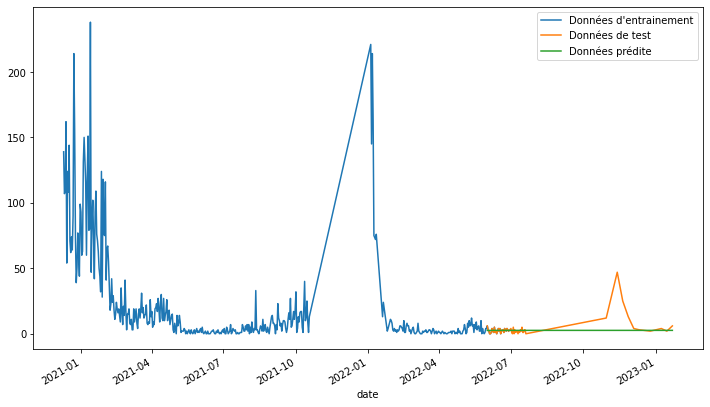

p : 2
q : 4
            cas  cas_pred
date                     
2022-06-01    6  2.532621
2022-06-02    3  2.120127
2022-06-03    2  2.012846
2022-06-04    0  2.461588
2022-06-05    0  2.766070
2022-06-06    1  2.661469
2022-06-07    4  2.423733
2022-06-08    2  2.358753
2022-06-09    1  2.465789
2022-06-10    5  2.561919
2022-06-11    1  2.549564
2022-06-12    2  2.485583
2022-06-13    0  2.458670
2022-06-14    2  2.482425
2022-06-15    4  2.511214
2022-06-16    2  2.512466
2022-06-17    4  2.495959
2022-06-18    0  2.486366
2022-06-19    2  2.491075
2022-06-20    3  2.499323
2022-06-21    3  2.500933
2022-06-22    1  2.496874
2022-06-23    4  2.493739
2022-06-24    3  2.494480
2022-06-25    2  2.496749
2022-06-26    4  2.497521
2022-06-27    3  2.496582
2022-06-28    2  2.495618
2022-07-01    4  2.495661
2022-07-02    1  2.496260
2022-07-03    0  2.496555
2022-07-04    5  2.496356
2022-07-05    0  2.496073
2022-07-06    3  2.496040
2022-07-07    1  2.496192
2022-07-09    2  2.496292


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


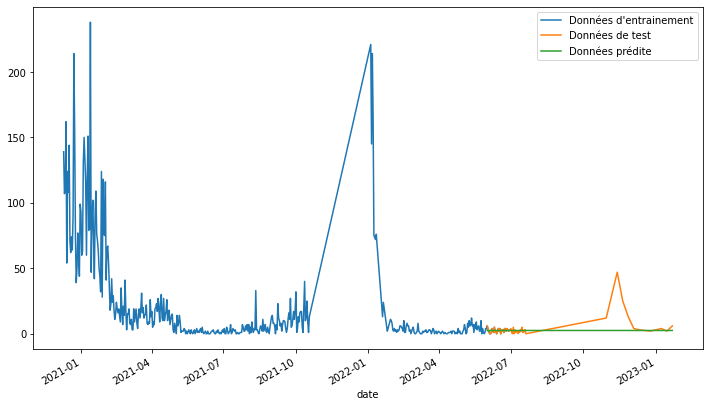

p : 3
q : 1
            cas  cas_pred
date                     
2022-06-01    6  2.576656
2022-06-02    3  2.552149
2022-06-03    2  2.510196
2022-06-04    0  2.552997
2022-06-05    0  2.560489
2022-06-06    1  2.564126
2022-06-07    4  2.570896
2022-06-08    2  2.574574
2022-06-09    1  2.577129
2022-06-10    5  2.579224
2022-06-11    1  2.580686
2022-06-12    2  2.581744
2022-06-13    0  2.582528
2022-06-14    2  2.583097
2022-06-15    4  2.583512
2022-06-16    2  2.583815
2022-06-17    4  2.584036
2022-06-18    0  2.584198
2022-06-19    2  2.584315
2022-06-20    3  2.584401
2022-06-21    3  2.584464
2022-06-22    1  2.584510
2022-06-23    4  2.584543
2022-06-24    3  2.584567
2022-06-25    2  2.584585
2022-06-26    4  2.584598
2022-06-27    3  2.584607
2022-06-28    2  2.584614
2022-07-01    4  2.584619
2022-07-02    1  2.584623
2022-07-03    0  2.584626
2022-07-04    5  2.584628
2022-07-05    0  2.584629
2022-07-06    3  2.584630
2022-07-07    1  2.584631
2022-07-09    2  2.584631


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


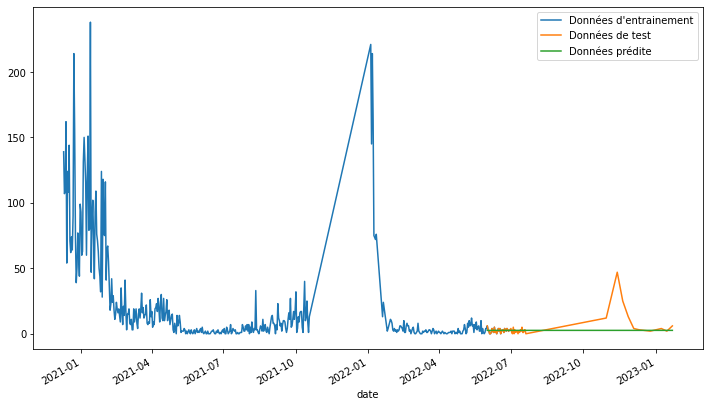

c:\Users\SANOU Mohamed Bachir\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\SANOU Mohamed Bachir\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p : 3
q : 2
            cas  cas_pred
date                     
2022-06-01    6  2.600318
2022-06-02    3  2.526232
2022-06-03    2  2.494270
2022-06-04    0  2.558474
2022-06-05    0  2.551629
2022-06-06    1  2.558839
2022-06-07    4  2.567546
2022-06-08    2  2.569351
2022-06-09    1  2.572358
2022-06-10    5  2.574391
2022-06-11    1  2.575549
2022-06-12    2  2.576549
2022-06-13    0  2.577215
2022-06-14    2  2.577677
2022-06-15    4  2.578019
2022-06-16    2  2.578255
2022-06-17    4  2.578424
2022-06-18    0  2.578544
2022-06-19    2  2.578629
2022-06-20    3  2.578689
2022-06-21    3  2.578732
2022-06-22    1  2.578763
2022-06-23    4  2.578784
2022-06-24    3  2.578799
2022-06-25    2  2.578810
2022-06-26    4  2.578818
2022-06-27    3  2.578823
2022-06-28    2  2.578827
2022-07-01    4  2.578830
2022-07-02    1  2.578832
2022-07-03    0  2.578833
2022-07-04    5  2.578834
2022-07-05    0  2.578835
2022-07-06    3  2.578836
2022-07-07    1  2.578836
2022-07-09    2  2.578836


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


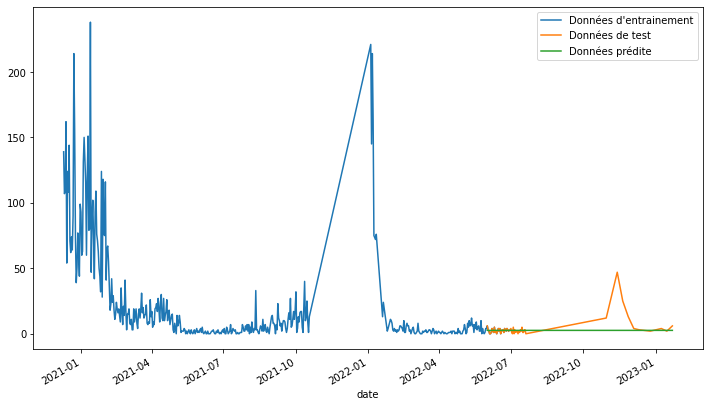

p : 3
q : 3
            cas  cas_pred
date                     
2022-06-01    6  2.344165
2022-06-02    3  1.930120
2022-06-03    2  1.979869
2022-06-04    0  2.471460
2022-06-05    0  2.715741
2022-06-06    1  2.515307
2022-06-07    4  2.284815
2022-06-08    2  2.334899
2022-06-09    1  2.513679
2022-06-10    5  2.552288
2022-06-11    1  2.447144
2022-06-12    2  2.379245
2022-06-13    0  2.423427
2022-06-14    2  2.487076
2022-06-15    4  2.482582
2022-06-16    2  2.437699
2022-06-17    4  2.422829
2022-06-18    0  2.447286
2022-06-19    2  2.467116
2022-06-20    3  2.458472
2022-06-21    3  2.441595
2022-06-22    1  2.440711
2022-06-23    4  2.451786
2022-06-24    3  2.456805
2022-06-25    2  2.451310
2022-06-26    4  2.445718
2022-06-27    3  2.447207
2022-06-28    2  2.451587
2022-07-01    4  2.452328
2022-07-02    1  2.449657
2022-07-03    0  2.448090
2022-07-04    5  2.449273
2022-07-05    0  2.450806
2022-07-06    3  2.450617
2022-07-07    1  2.449503
2022-07-09    2  2.449187


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


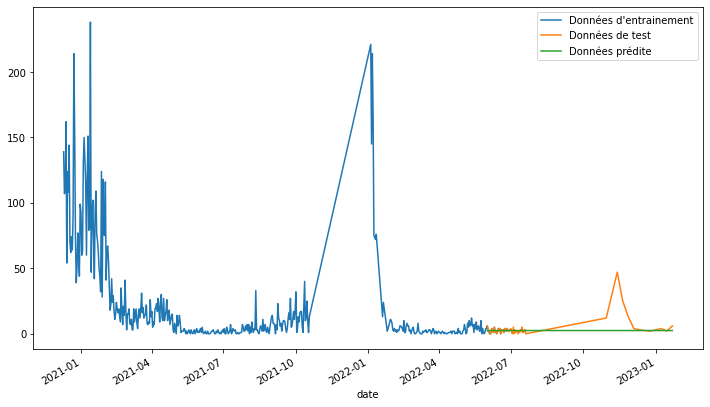

p : 3
q : 4
            cas  cas_pred
date                     
2022-06-01    6  2.373730
2022-06-02    3  1.971422
2022-06-03    2  1.983118
2022-06-04    0  2.459619
2022-06-05    0  2.720331
2022-06-06    1  2.543843
2022-06-07    4  2.313748
2022-06-08    2  2.339360
2022-06-09    1  2.500314
2022-06-10    5  2.548945
2022-06-11    1  2.464243
2022-06-12    2  2.398665
2022-06-13    0  2.427266
2022-06-14    2  2.481338
2022-06-15    4  2.484540
2022-06-16    2  2.450740
2022-06-17    4  2.435063
2022-06-18    0  2.450687
2022-06-19    2  2.467148
2022-06-20    3  2.463633
2022-06-21    3  2.451536
2022-06-22    1  2.448950
2022-06-23    4  2.455759
2022-06-24    3  2.460177
2022-06-25    2  2.457537
2022-06-26    4  2.453607
2022-06-27    3  2.453739
2022-06-28    2  2.456343
2022-07-01    4  2.457304
2022-07-02    1  2.456002
2022-07-03    0  2.454854
2022-07-04    5  2.455237
2022-07-05    0  2.456136
2022-07-06    3  2.456249
2022-07-07    1  2.455711
2022-07-09    2  2.455421


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


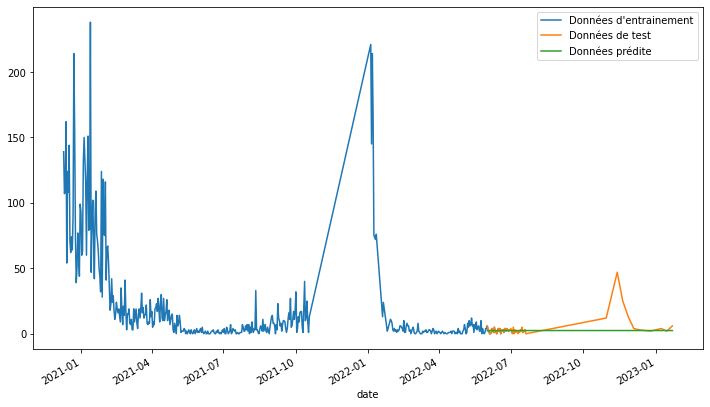

p : 4
q : 1
            cas  cas_pred
date                     
2022-06-01    6  2.618502
2022-06-02    3  2.483785
2022-06-03    2  2.451526
2022-06-04    0  2.550992
2022-06-05    0  2.532064
2022-06-06    1  2.541468
2022-06-07    4  2.555850
2022-06-08    2  2.554380
2022-06-09    1  2.557804
2022-06-10    5  2.559992
2022-06-11    1  2.560224
2022-06-12    2  2.561061
2022-06-13    0  2.561452
2022-06-14    2  2.561601
2022-06-15    4  2.561787
2022-06-16    2  2.561871
2022-06-17    4  2.561919
2022-06-18    0  2.561961
2022-06-19    2  2.561981
2022-06-20    3  2.561994
2022-06-21    3  2.562003
2022-06-22    1  2.562008
2022-06-23    4  2.562012
2022-06-24    3  2.562014
2022-06-25    2  2.562015
2022-06-26    4  2.562016
2022-06-27    3  2.562016
2022-06-28    2  2.562017
2022-07-01    4  2.562017
2022-07-02    1  2.562017
2022-07-03    0  2.562017
2022-07-04    5  2.562017
2022-07-05    0  2.562017
2022-07-06    3  2.562017
2022-07-07    1  2.562017
2022-07-09    2  2.562017


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


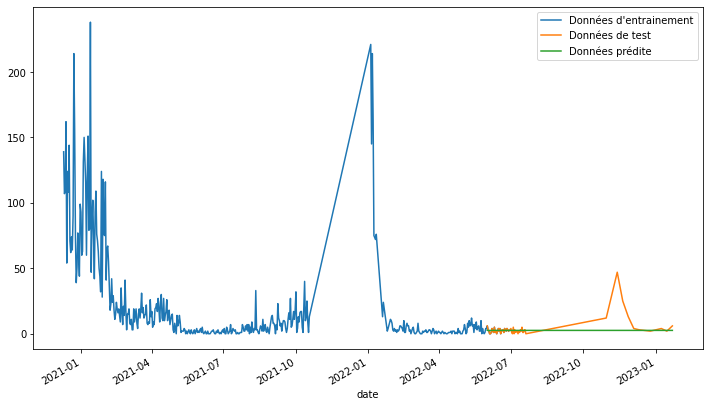

p : 4
q : 2


c:\Users\SANOU Mohamed Bachir\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\SANOU Mohamed Bachir\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


            cas  cas_pred
date                     
2022-06-01    6  2.575528
2022-06-02    3  2.549130
2022-06-03    2  2.509023
2022-06-04    0  2.552561
2022-06-05    0  2.558852
2022-06-06    1  2.563407
2022-06-07    4  2.569798
2022-06-08    2  2.573674
2022-06-09    1  2.576098
2022-06-10    5  2.578295
2022-06-11    1  2.579672
2022-06-12    2  2.580777
2022-06-13    0  2.581520
2022-06-14    2  2.582107
2022-06-15    4  2.582500
2022-06-16    2  2.582810
2022-06-17    4  2.583020
2022-06-18    0  2.583183
2022-06-19    2  2.583295
2022-06-20    3  2.583381
2022-06-21    3  2.583441
2022-06-22    1  2.583486
2022-06-23    4  2.583518
2022-06-24    3  2.583542
2022-06-25    2  2.583559
2022-06-26    4  2.583572
2022-06-27    3  2.583581
2022-06-28    2  2.583587
2022-07-01    4  2.583592
2022-07-02    1  2.583596
2022-07-03    0  2.583598
2022-07-04    5  2.583600
2022-07-05    0  2.583601
2022-07-06    3  2.583602
2022-07-07    1  2.583603
2022-07-09    2  2.583604
2022-07-10  

C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


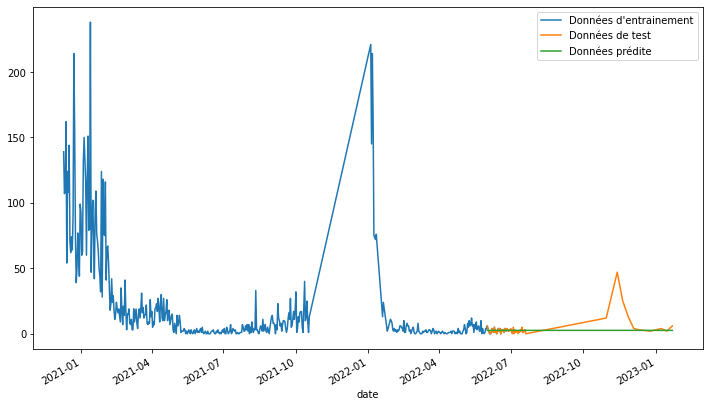

p : 4
q : 3
            cas  cas_pred
date                     
2022-06-01    6  2.357341
2022-06-02    3  1.949600
2022-06-03    2  1.981220
2022-06-04    0  2.465066
2022-06-05    0  2.717556
2022-06-06    1  2.529096
2022-06-07    4  2.298867
2022-06-08    2  2.336931
2022-06-09    1  2.506834
2022-06-10    5  2.550192
2022-06-11    1  2.455084
2022-06-12    2  2.388463
2022-06-13    0  2.425011
2022-06-14    2  2.483824
2022-06-15    4  2.483065
2022-06-16    2  2.443745
2022-06-17    4  2.428550
2022-06-18    0  2.448570
2022-06-19    2  2.466646
2022-06-20    3  2.460581
2022-06-21    3  2.446166
2022-06-22    1  2.444435
2022-06-23    4  2.453307
2022-06-24    3  2.457998
2022-06-25    2  2.453985
2022-06-26    4  2.449270
2022-06-27    3  2.450050
2022-06-28    2  2.453490
2022-07-01    4  2.454346
2022-07-02    1  2.452405
2022-07-03    0  2.451063
2022-07-04    5  2.451814
2022-07-05    0  2.453005
2022-07-06    3  2.452982
2022-07-07    1  2.452183
2022-07-09    2  2.451879


C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


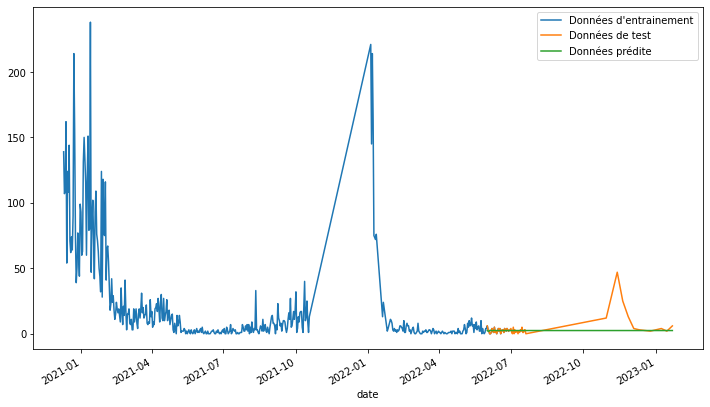

p : 4
q : 4


c:\Users\SANOU Mohamed Bachir\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\SANOU Mohamed Bachir\AppData\Local\Temp\ipykernel_11432\2926247593.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['cas_pred'] = pred


            cas  cas_pred
date                     
2022-06-01    6  2.397827
2022-06-02    3  1.979548
2022-06-03    2  1.978336
2022-06-04    0  2.460098
2022-06-05    0  2.724331
2022-06-06    1  2.552680
2022-06-07    4  2.318343
2022-06-08    2  2.336533
2022-06-09    1  2.497632
2022-06-10    5  2.553757
2022-06-11    1  2.472737
2022-06-12    2  2.402549
2022-06-13    0  2.425892
2022-06-14    2  2.481245
2022-06-15    4  2.489200
2022-06-16    2  2.456570
2022-06-17    4  2.437778
2022-06-18    0  2.451126
2022-06-19    2  2.468906
2022-06-20    3  2.467660
2022-06-21    3  2.455591
2022-06-22    1  2.451360
2022-06-23    4  2.457433
2022-06-24    3  2.462717
2022-06-25    2  2.460979
2022-06-26    4  2.456821
2022-06-27    3  2.456214
2022-06-28    2  2.458661
2022-07-01    4  2.460077
2022-07-02    1  2.459079
2022-07-03    0  2.457742
2022-07-04    5  2.457833
2022-07-05    0  2.458738
2022-07-06    3  2.459058
2022-07-07    1  2.458603
2022-07-09    2  2.458206
2022-07-10  

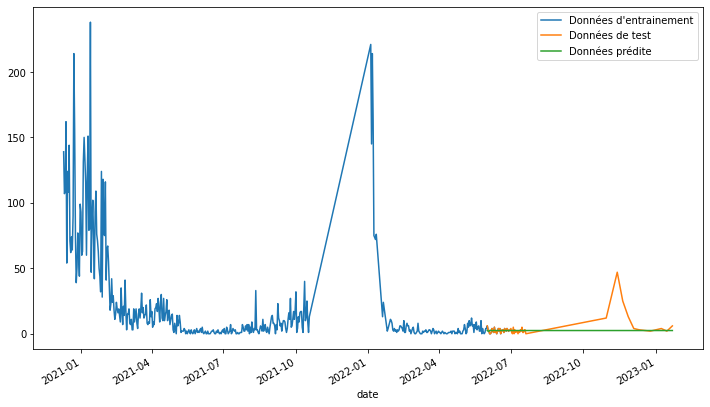

In [32]:
for p in range(1, 5) :
    for q in range(1,5) :
        print('p :', p)
        print('q :',q)
        affichage_araima (train,test,p,q)